# Detecting artifacts in EEG time series

In [95]:
import os
import pandas as pd
import numpy as np
import mne

%matplotlib notebook

In [106]:
df = pd.read_csv("data/02-08-2020-jv-baseline-activity-no-labels-BBT-E16-AAA005-2020-02-08_12-59-21/EEG.csv")

df_mne = df.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)
data_mne = df_mne.to_numpy().transpose() / 10000000

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz']

info_mne = mne.create_info(
    #ch_names=list(df_mne.columns),
    ch_names=channels,
    ch_types='eeg',
    sfreq=256)

bbt_raw = mne.io.RawArray(data_mne, info_mne)

ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

raw = bbt_raw.copy().set_montage(ten_twenty_montage)

Creating RawArray with float64 data, n_channels=16, n_times=60712
    Range : 0 ... 60711 =      0.000 ...   237.152 secs
Ready.
DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'AF9', 'FC4', 'PO1', 'AF1', 'PO4', 'AF4', 'FT9', 'F9', 'P4', 'AF3', 'AF6', 'TP9', 'FT8', 'CP5', 'FC3', 'CP6', 'T8', 'F2', 'A2', 'P7', 'P1', 'T6', 'F1', 'AF2', 'TP10', 'FC2', 'P9', 'P5', 'P10', 'F10', 'O10', 'PO8', 'PO3', 'PO7', 'Iz', 'P2', 'AF5', 'FT10', 'F8', 'O9', 'PO6', 'AF8', 'C5', 'FT7', 'Fz', 'PO5', 'FC1', 'FCz', 'T5', 'Fpz', 'T7', 'T9', 'POz', 'PO2', 'F6', 'TP8', 'T10', 'FC6', 'AF10', 'P8', 'CPz', 'P3', 'FC5', 'M1', 'M2', 'AFz', 'PO10', 'AF7', 'T3', 'A1', 'T4', 'C6', 'F5', 'Oz', 'P6', 'TP7', 'PO9', 'F7'}


In [107]:
raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

<RawArray  |  None, n_channels x n_times : 16 x 15361 (60.0 sec), ~1.9 MB, data loaded>

In [108]:
ssp_projectors = raw.info['projs']
raw.del_proj()

<RawArray  |  None, n_channels x n_times : 16 x 15361 (60.0 sec), ~1.9 MB, data loaded>

<IPython.core.display.Javascript object>


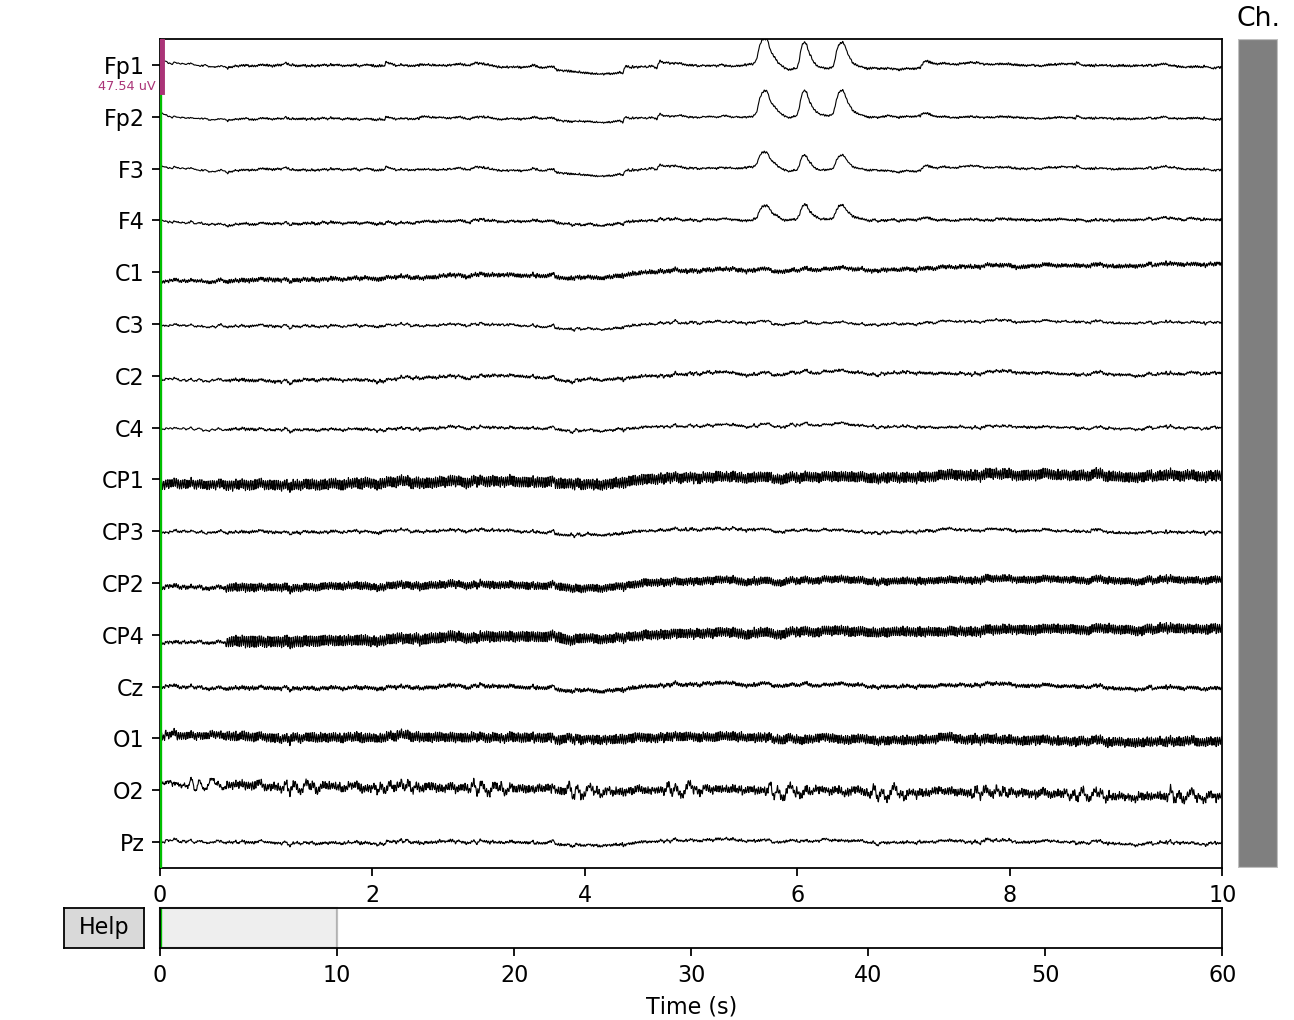

<IPython.core.display.Javascript object>


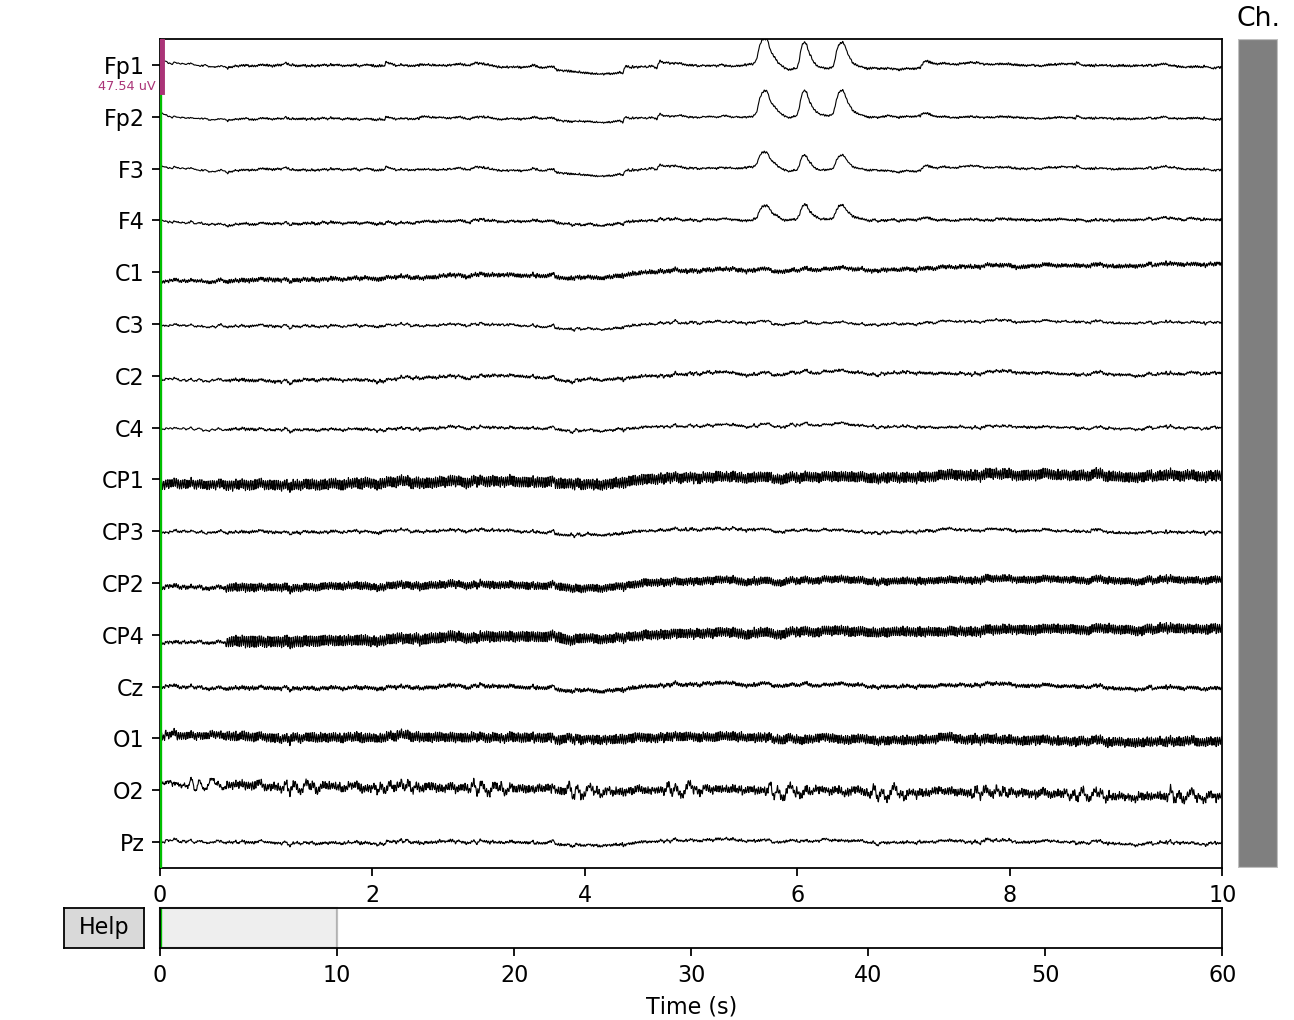

In [115]:
raw.plot(scalings = 'auto')

<IPython.core.display.Javascript object>


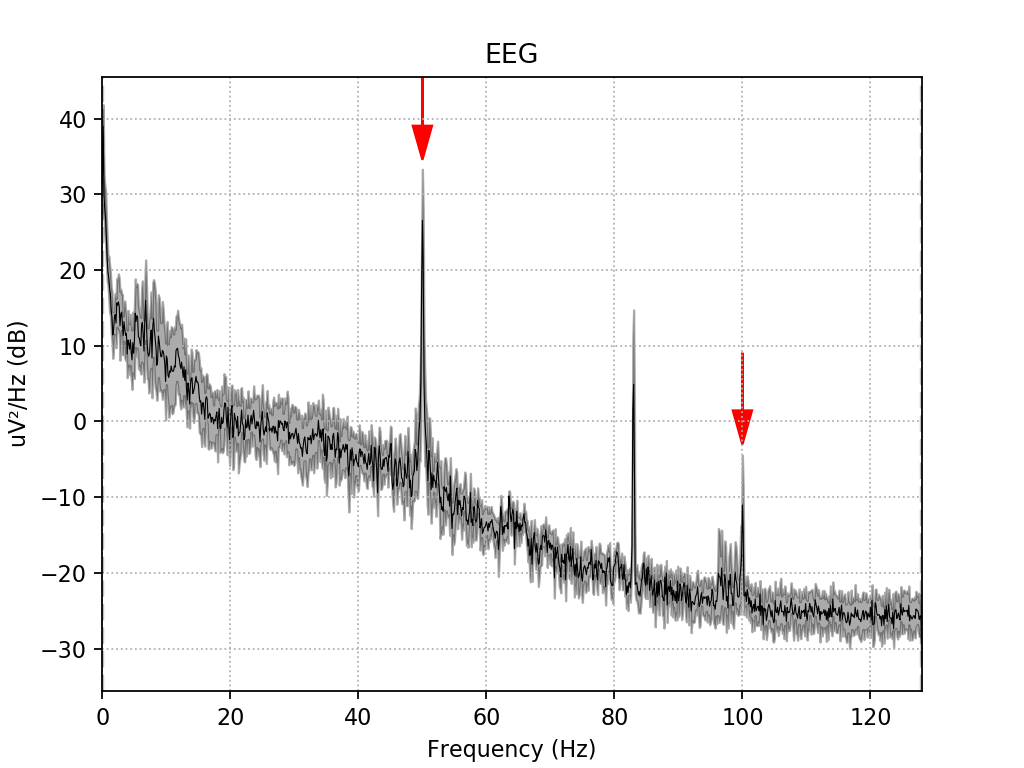

Effective window size : 8.000 (s)


In [9]:
fig = raw.plot_psd(tmax=np.inf, fmax=128, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (50, 100):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 20, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

Using channel Fp1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 4096 samples (16.000 sec)

Now detecting blinks and generating corresponding events
Found 8 significant peaks
Number of EOG events detected : 8
8 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Loading data for 8 events and 257 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


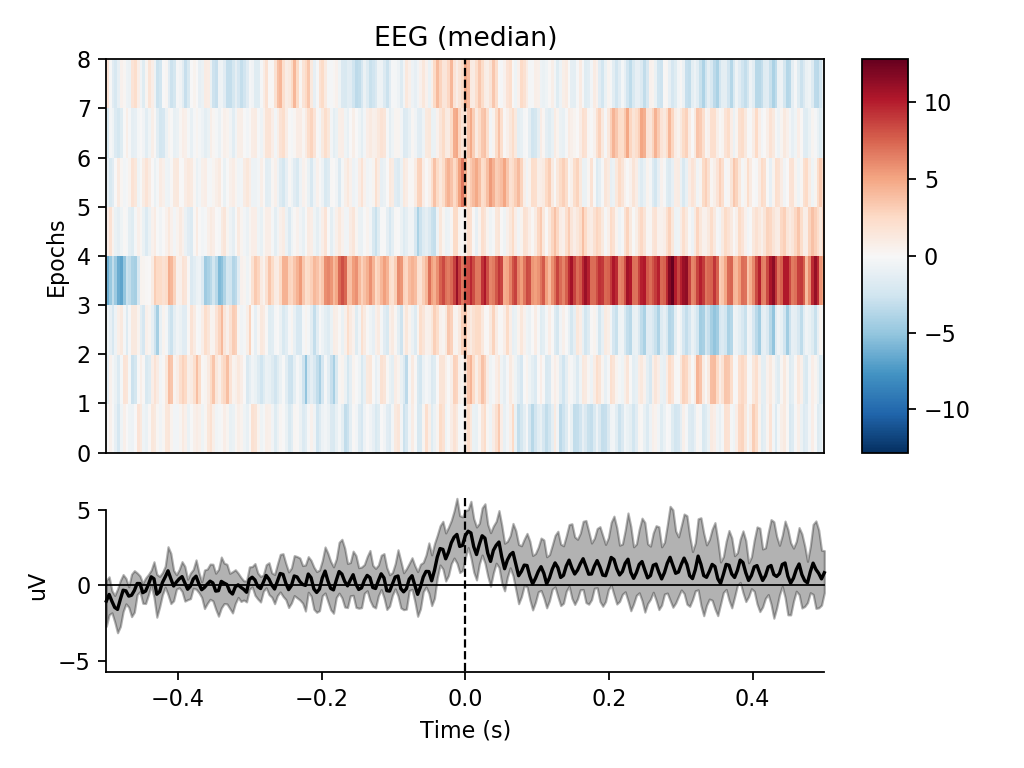

8 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "median"


<IPython.core.display.Javascript object>


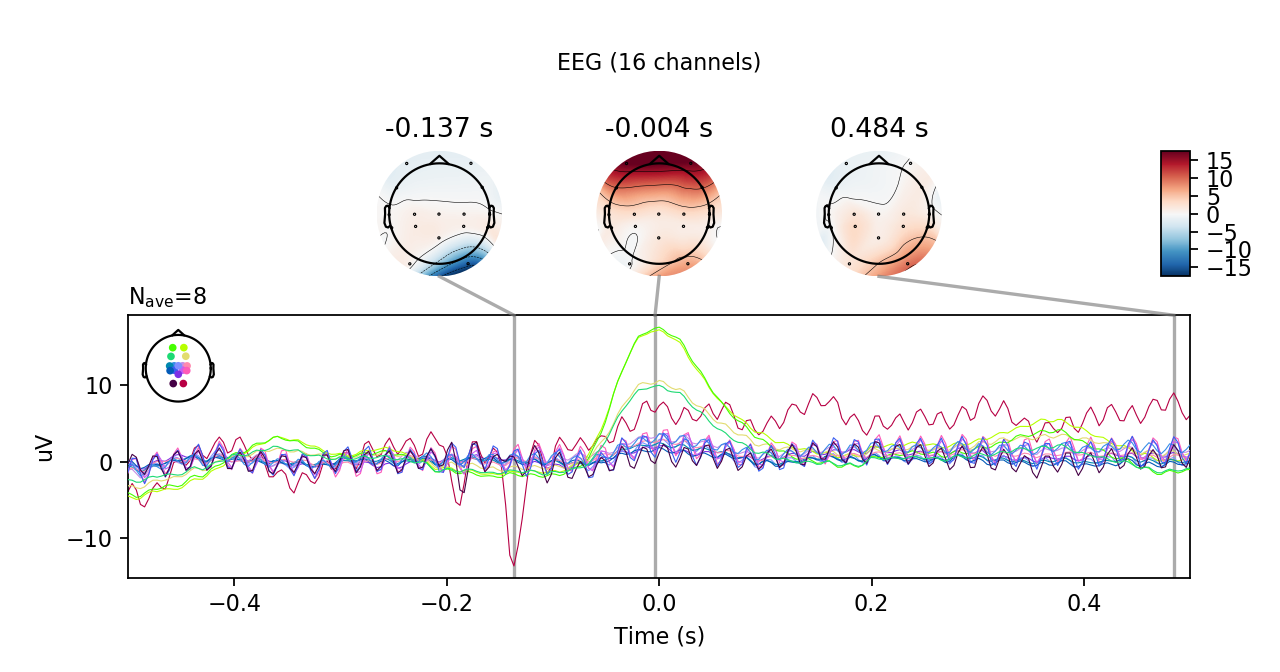

<IPython.core.display.Javascript object>


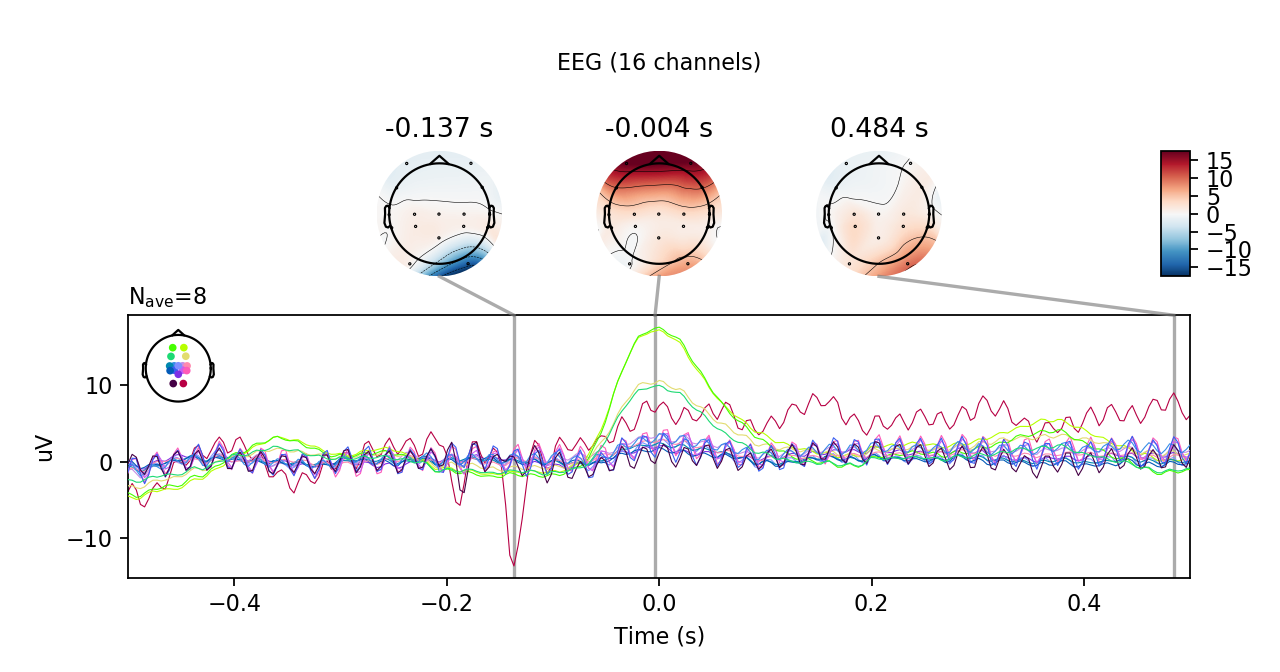

In [114]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name="Fp1", baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='median')
eog_epochs.average().plot_joint()